In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import cartopy; print('cartopy', cartopy.__version__)
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import numpy as np
import seaborn as sns
import gcsfs
from pathlib import Path
import yaml
#cartopy text scale issues
sns.set_context('paper', font_scale=.9)

cartopy 0.17.0


### setup data access

In [2]:
gcsfs.core.client_config['installed']['client_id'] = '160816776314-7h1p2h6bqhe77vs1su4rr22fblso9dre.apps.googleusercontent.com'
gcsfs.core.client_config['installed']['client_secret'] = 'SrJUwD58yKgViyJtw-NP2sz8'

In [3]:
# create a GCSFileSystem just for the purpose of authentication
gcs_orig = gcsfs.GCSFileSystem(project='malariagen-jupyterhub', token='cache', cache_timeout=0)

# create another one with those credentials
gcs =  gcsfs.GCSFileSystem(project='malariagen-jupyterhub', token=gcs_orig.session.credentials, cache_timeout=0)

### setup data

In [4]:
staging_dir = Path("vo_agam_staging")
species_analysis = "species_calls_20200422"

In [8]:
with open("../data/config.yml", "r") as yy:
    config = yaml.load(yy, Loader=yaml.Loader)

samplesets = sorted(config["sample_sets"])

#GA-B is empty, crosses we don't want
samplesets.remove('AG1000G-GA-B')
samplesets.remove('AG1000G-X')

In [11]:
samplesets

['AG1000G-AO',
 'AG1000G-BF-A',
 'AG1000G-BF-B',
 'AG1000G-BF-C',
 'AG1000G-CD',
 'AG1000G-CF',
 'AG1000G-CI',
 'AG1000G-CM-A',
 'AG1000G-CM-B',
 'AG1000G-CM-C',
 'AG1000G-FR',
 'AG1000G-GA-A',
 'AG1000G-GH',
 'AG1000G-GM-A',
 'AG1000G-GM-B',
 'AG1000G-GM-C',
 'AG1000G-GN-A',
 'AG1000G-GN-B',
 'AG1000G-GQ',
 'AG1000G-GW',
 'AG1000G-KE',
 'AG1000G-ML-A',
 'AG1000G-ML-B',
 'AG1000G-MW',
 'AG1000G-MZ',
 'AG1000G-TZ',
 'AG1000G-UG']

In [9]:
#need to get mean lon/lat across countries so we might as well concat all metadata including species into a big PD

set_len = 0
all_meta = pd.DataFrame()

for sset in samplesets:
        
        metadata_path = staging_dir / "v3" / "metadata" / "general" / sset / "samples.meta.csv"
        species_path = staging_dir / "v3" / "metadata" / species_analysis / sset / "samples.species_aim.csv"


        with gcs.open(metadata_path) as gcs_fh:
            df = pd.read_csv(gcs_fh, index_col=0)
        with gcs.open(species_path) as gcs_fh:
            df_aim = pd.read_csv(gcs_fh, index_col=0)

        # join on sample id
        result = pd.concat([df, df_aim], axis=1, sort=False)
        set_len += len(result)

        all_meta = pd.concat([all_meta, result],sort=False)

assert len(all_meta) == set_len

In [23]:
countries = list(all_meta.country.unique())
countries

['Angola',
 'Burkina Faso',
 'Democratic Republic of Congo',
 'Central African Republic',
 "Cote d'Ivoire",
 'Cameroon',
 'Mayotte',
 'Gabon',
 'Ghana',
 'Gambia, The',
 'Guinea',
 'Mali',
 'Equatorial Guinea',
 'Guinea-Bissau',
 'Kenya',
 'Malawi',
 'Mozambique',
 'Tanzania',
 'Uganda']

In [28]:
#code to get a single averaged lat/lon and species composition for each country
def plot_pyr_map(dpi=150, extent=[-22, 48, -25, 15], figsize=(10, 4), label_fontsize=7):
    subplot_kw = dict(projection=ccrs.PlateCarree())
    fig, ax = plt.subplots(figsize=figsize, subplot_kw=subplot_kw, dpi=120)
    ax.add_feature(cfeature.LAND, linewidth=1, zorder=1)
    ax.coastlines(resolution='50m', linewidth=1, zorder=2)
    ax.add_feature(cfeature.BORDERS, linewidth=1, zorder=5)
    
    for c in countries:
        df = all_meta[all_meta.country == c]

        #get an average lonlat for each country
        lon = np.mean(df.longitude.unique())
        lat = np.mean(df.latitude.unique())

        centre = (lon, lat)
        radius=0.2
        ax.add_patch(plt.Circle(xy=centre, radius=radius, facecolor='none', edgecolor='r', zorder=8, lw=1.5))

    ax.set_extent(extent)         


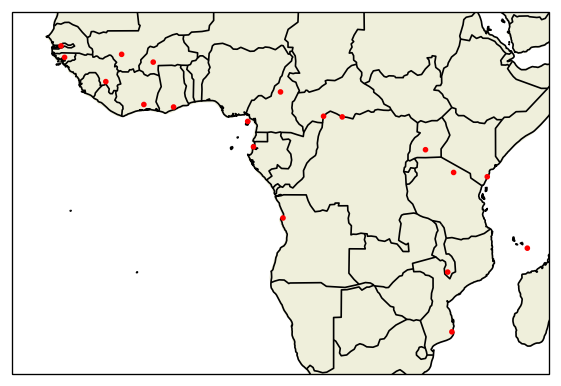

In [29]:
plot_pyr_map()

In [17]:
#sex as well as species?